In [1]:
import polars as pl
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
from utils import remove_extra_brackets

In [2]:
df = pl.read_csv("../data/train.csv")

We can see that we have a lot  of column but we must keep in mind that in the test dataset we will only be provided with **prompt**, **response_a** and **response_b**.

From initial observation we can see that prompt, response_a and response_b are enclosed in a list containing the text so we must fix that!
Further more the winner is provided in columns **winner_model_a**,**winner_model_b** and **winner_tie** with the correct option highlighted as 1 and the rest are 0.

In [3]:
text = df["prompt"].sample(1)[0]
print(f"{'Prompt':<12}: {text}")
text = df["response_a"].sample(1)[0]
print(f"{'Response_a':<12}: {text}")
text = df["response_b"].sample(1)[0]
print(f"{'Response_b':<12}: {text}")

Prompt      : ["build a 30 day meal plan to feed a 6 month old baby"]
Response_a  : ["mondo points are a form of\u5938\u5956 or criticism given to a person or thing for having a certain quality or behavior. In this context, the expression\u201cmondo points\u201dmeans that the author is\u8d5e\u626c or\u6279\u8bc4 the book\\'s syntax, which is using the size of an array as a way to deduced the type of a variable, in a way that is considered harmful or toxic by some people. It\\'s worth noting that the context of the passage is not clear, and it\\'s possible that the author is simply using the term\u201cmondo points\u201d as a humorous way to describe the syntax, rather than being critical."]
Response_b  : ["Here is an example of an inline JavaScript code that animates a planet orbiting two stars in a figure 8 pattern:\n\n```html\n<!DOCTYPE html>\n<html>\n<body>\n\n<canvas id=\"myCanvas\" width=\"800\" height=\"600\" style=\"border:1px solid #d3d3d3;\">\nYour browser does not support the 

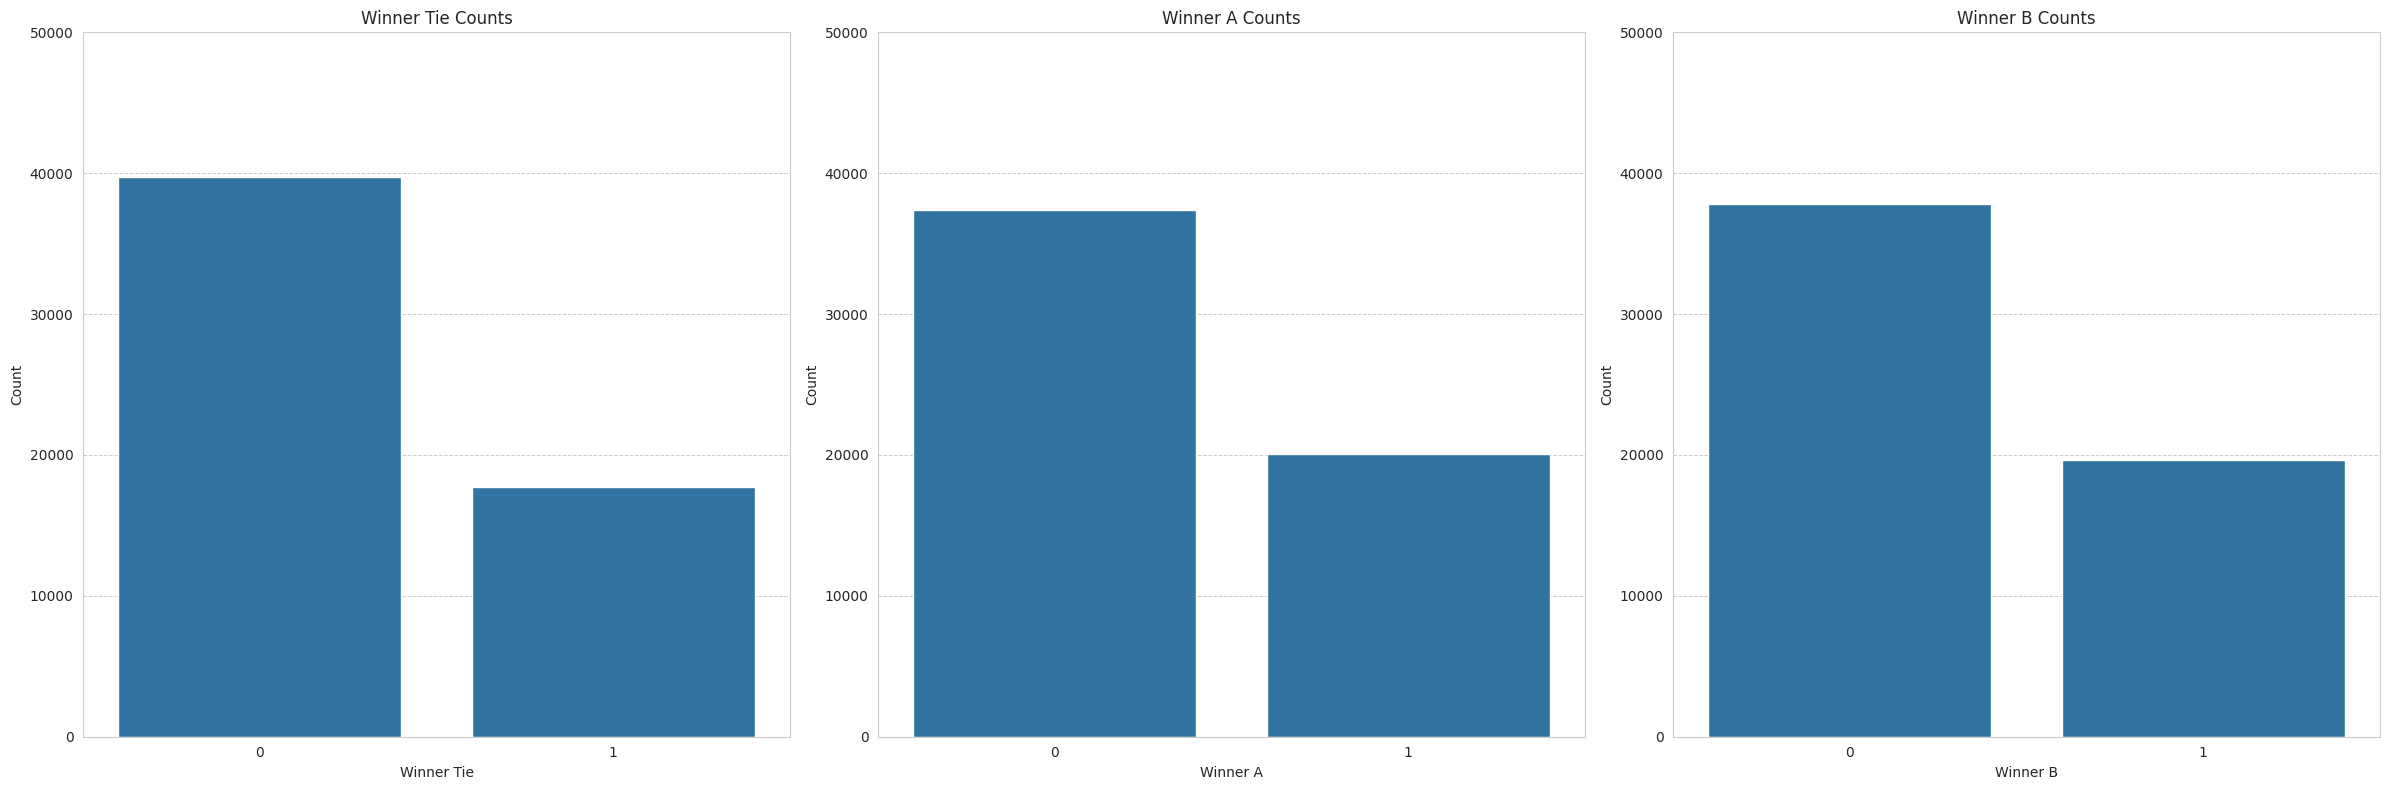

In [4]:
fig, ax = plt.subplots(1,3, figsize=(24, 8))
yticks = np.arange(0, 55000, 10000)

sns.countplot(x=df["winner_tie"].to_list(), ax=ax[0]);
ax[0].set_title("Winner Tie Counts")
ax[0].set_xlabel("Winner Tie")
ax[0].set_ylabel("Count")
ax[0].set_yticks(yticks)
ax[0].grid(axis='y',  which='major', linestyle='--', linewidth=0.7)

sns.countplot(x=df["winner_model_a"].to_list(), ax=ax[1]);
ax[1].set_title("Winner A Counts")
ax[1].set_xlabel("Winner A")
ax[1].set_ylabel("Count")
ax[1].set_yticks(yticks)
ax[1].grid(axis='y', which='major', linestyle='--', linewidth=0.7)

sns.countplot(x=df["winner_model_b"].to_list(), ax=ax[2]);
ax[2].set_title("Winner B Counts")
ax[2].set_xlabel("Winner B")
ax[2].set_ylabel("Count")
ax[2].set_yticks(yticks)
ax[2].grid(axis='y', which='major', linestyle='--', linewidth=0.7)

plt.tight_layout()
plt.show()

As we can see the dataset is already balanced as there is no evidence of users prefering the option 1 more that option 2 which i have seen in a research paper that was detected.

In [5]:
df = df.with_columns([
    pl.col("prompt").map_elements(remove_extra_brackets, return_dtype=pl.String),
    pl.col("response_a").map_elements(remove_extra_brackets, return_dtype=pl.String),
    pl.col("response_b").map_elements(remove_extra_brackets, return_dtype=pl.String),
])

In [6]:
df = df.with_columns(
    pl.when(pl.col('winner_model_a')==1).then(pl.col('model_a')).when(pl.col('winner_model_b')==1).then(pl.col('model_b')).otherwise(None).alias("final_winner")
)

In [7]:
models_a = df['model_a'].value_counts()
models_b = df['model_b'].value_counts()
winners = df['final_winner'].value_counts()

In [8]:
models = {}

for row in models_a.iter_rows():
    name = row[0]
    count = row[1]
    if name in models.keys():
        models[name] += count
    else:
        models[name] = count
        
for row in models_b.iter_rows():
    name = row[0]
    count = row[1]
    if name in models.keys():
        models[name] += count
    else:
        models[name] = count

In [9]:
models_used_df = pl.DataFrame([models]).unpivot(variable_name="model", value_name="count")

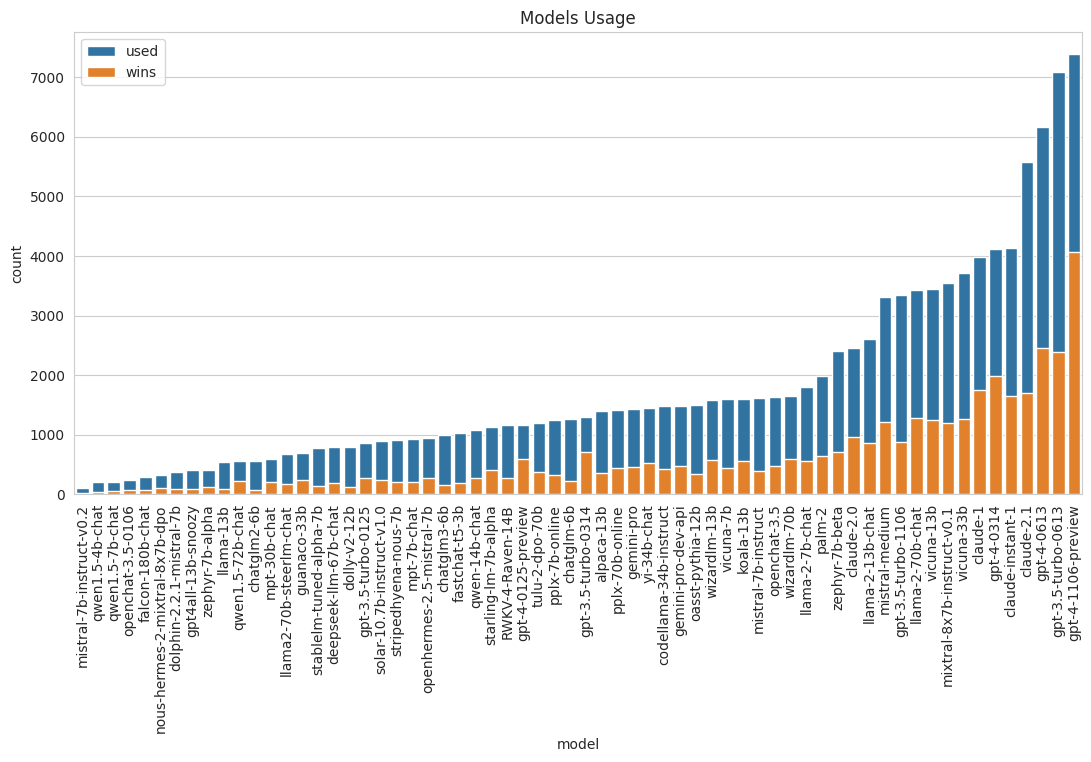

In [10]:
plt.figure(figsize=(13,6))
sns.barplot(models_used_df.sort("count"), x="model", y="count", label="used")
sns.barplot(winners, x="final_winner", y="count", label="wins")
plt.title("Models Usage")
plt.xticks(rotation=90);
plt.show()

In [11]:
final_model_leadearboard = models_used_df.join(winners, left_on="model", right_on="final_winner", suffix="_wins")

In [12]:
final_model_leadearboard = final_model_leadearboard.with_columns(
    ((pl.col("count_wins")/pl.col("count"))*100).alias("win_percentage")
)

/tmp/ipykernel_27014/2094008093.py:2: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#D3AF37'` for the same effect.

  sns.barplot(final_model_leadearboard.sort("win_percentage"), x="model", y="win_percentage", color="#D3AF37", hue="win_percentage");


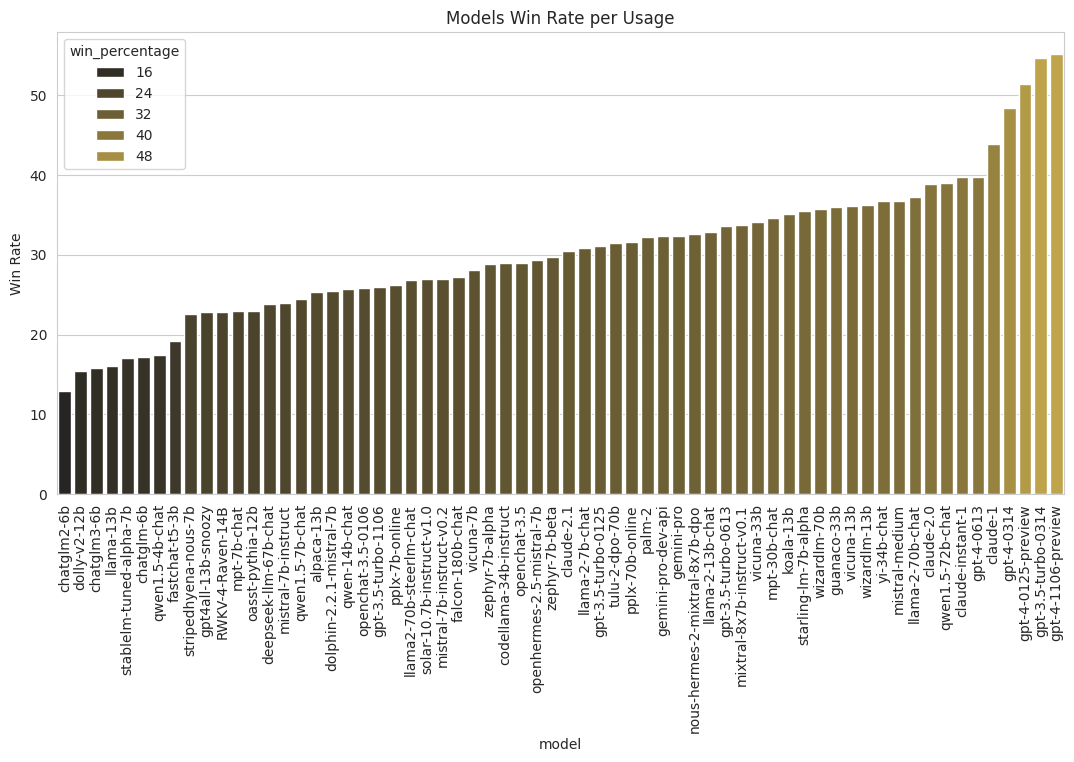

In [13]:
plt.figure(figsize=(13,6))
sns.barplot(final_model_leadearboard.sort("win_percentage"), x="model", y="win_percentage", color="#D3AF37", hue="win_percentage");
plt.title("Models Win Rate per Usage");
plt.ylabel("Win Rate")
plt.xticks(rotation=90);
plt.show()

In [14]:
df = df.with_columns(
    pl.col("prompt").str.len_chars().alias("prompt_length"),
    pl.col("response_a").str.len_chars().alias("response_a_length"),
    pl.col("response_b").str.len_chars().alias("response_b_length"),
)

In [15]:
df = df.with_columns(
    pl.when(pl.col("winner_model_a")==1)
        .then((pl.col("response_a_length").cast(pl.Int64) - pl.col("response_b_length").cast(pl.Int64)))
    .when(pl.col("winner_model_b")==1)
        .then((pl.col("response_b_length").cast(pl.Int64) - pl.col("response_a_length").cast(pl.Int64)))
    .alias("winner_length_diff")
)

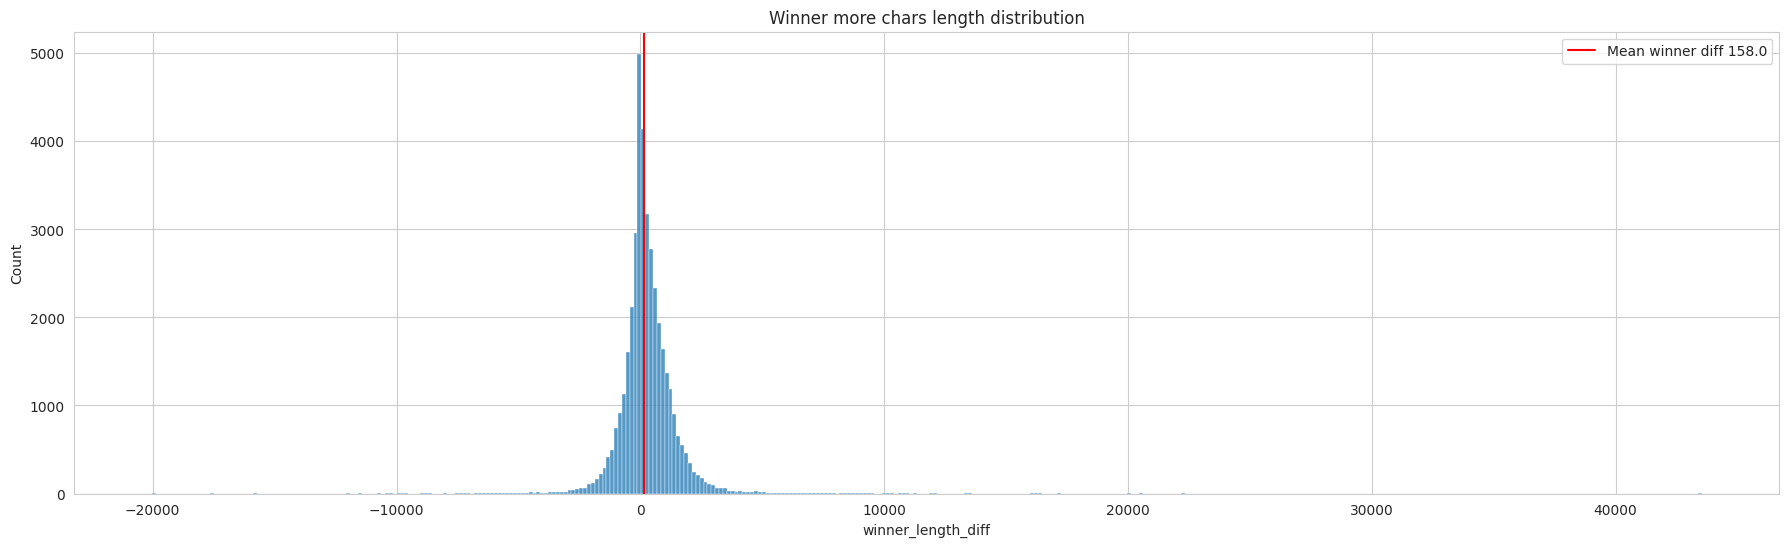

In [16]:
plt.figure(figsize=(22,6))
sns.histplot(df, x="winner_length_diff")
plt.axvline(x=df["winner_length_diff"].median(), color="red", label=f"Mean winner diff {df["winner_length_diff"].median()}")
plt.legend()
plt.title("Winner more chars length distribution")
plt.show()

Text(0.5, 1.0, 'Winner length diff per prompt length')

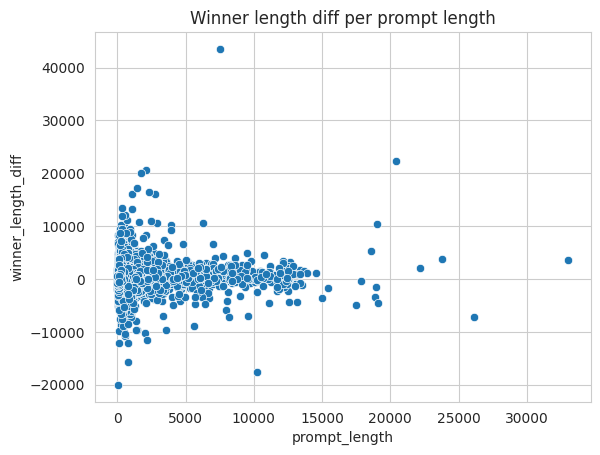

In [17]:
sns.scatterplot(df, x="prompt_length", y = "winner_length_diff")
plt.title("Winner length diff per prompt length")

In [18]:
df = df.with_columns(
    pl.col("response_a").str.count_matches(r"[.?!,:;]").alias("response_a_punctuations_length"),
    pl.col("response_b").str.count_matches(r"[.?!,:;]").alias("response_b_punctuations_length"),
)

In [19]:
df = df.with_columns(
    pl.when(pl.col("winner_model_a")==1)
        .then((pl.col("response_a_punctuations_length").cast(pl.Int64) - pl.col("response_b_punctuations_length").cast(pl.Int64)))
    .when(pl.col("winner_model_b")==1)
        .then((pl.col("response_b_punctuations_length").cast(pl.Int64) - pl.col("response_a_punctuations_length").cast(pl.Int64)))
    .alias("winner_punctuation_length_diff")
)

Text(0.5, 1.0, 'Winner punctuation count diff per prompt')

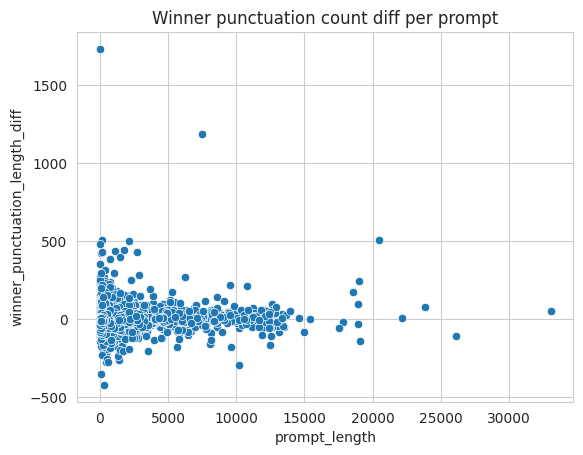

In [20]:
sns.scatterplot(df, x="prompt_length", y = "winner_punctuation_length_diff")
plt.title("Winner punctuation count diff per prompt")

In [21]:
df = df.with_columns(
    pl.col("response_a").str.count_matches(r"\r\\n|\\r|\\n").alias("response_a_newlines_count"),
    pl.col("response_b").str.count_matches(r"\r\\n|\\r|\\n").alias("response_b_newlines_count"),
)

df = df.with_columns(
    pl.when(pl.col("winner_model_a")==1)
        .then((pl.col("response_a_newlines_count").cast(pl.Int64) - pl.col("response_b_newlines_count").cast(pl.Int64)))
    .when(pl.col("winner_model_b")==1)
        .then((pl.col("response_b_newlines_count").cast(pl.Int64) - pl.col("response_a_newlines_count").cast(pl.Int64)))
    .alias("winner_new_lines_count_diff")
)

Text(0.5, 1.0, 'Winner punctuation count diff per prompt')

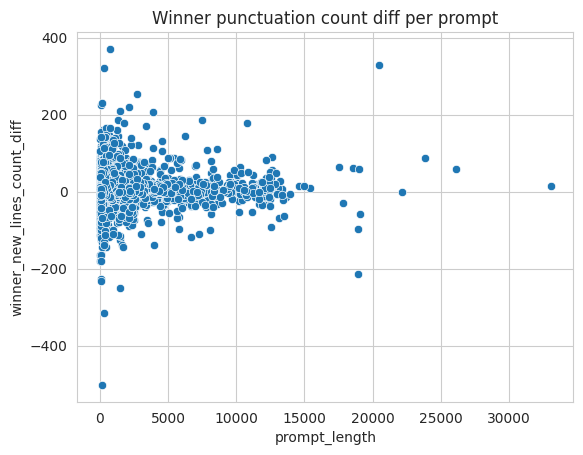

In [24]:
sns.scatterplot(df, x="prompt_length", y = "winner_new_lines_count_diff")
plt.title("Winner punctuation count diff per prompt")